https://sciencecareer.data.blog/2020/05/04/auto-colorization-of-black-and-white-images-using-machine-learning-auto-encoders-technique/

In [1]:
import os
import glob
import cv2
import time
import random
import webbrowser
import numpy as np
import pandas as pd
from numpy import reshape
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import savefig


import tensorflow as tf
#from tensorflow.keras import datasets, layers, models
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Flatten, InputLayer, BatchNormalization, Input, RepeatVector, concatenate
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from skimage import color
from skimage.io import imsave
from skimage.transform import resize
from skimage.io import imsave, imread, imshow
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function       #repasar funcion y explicar en exposicion

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

In [2]:
# Get images
img = []
for filename in os.listdir('colorReduced/'):
    img.append(img_to_array(load_img('colorReduced/'+filename)))

In [3]:
len(img)

843

In [4]:
X = []
Y = []

for x in img:
    lab = rgb2lab(x)
    X.append(lab[:,:,0])
    Y.append(lab[:,:,1:] / 128)

In [5]:
X = np.asarray(X, dtype=float)/255.0
Y = np.asarray(Y, dtype=float)/255.0

In [6]:
#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=encoder_input, outputs=decoder_output)

In [8]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse' , metrics=['accuracy'])
history = model.fit(X,Y,validation_split=0.1, epochs=20)

Epoch 1/20
24/24 [==============================] - 151s 6s/step - loss: 0.1179 - accuracy: 0.5317 - val_loss: 0.0043 - val_accuracy: 0.6644
Epoch 2/20
24/24 [==============================] - 140s 6s/step - loss: 0.0043 - accuracy: 0.6565 - val_loss: 0.0043 - val_accuracy: 0.6653
Epoch 3/20
24/24 [==============================] - 139s 6s/step - loss: 0.0042 - accuracy: 0.6574 - val_loss: 0.0044 - val_accuracy: 0.6653
Epoch 4/20
24/24 [==============================] - 137s 6s/step - loss: 0.0042 - accuracy: 0.6430 - val_loss: 0.0043 - val_accuracy: 0.6653
Epoch 5/20
24/24 [==============================] - 138s 6s/step - loss: 0.0042 - accuracy: 0.6472 - val_loss: 0.0043 - val_accuracy: 0.6653
Epoch 6/20
24/24 [==============================] - 146s 6s/step - loss: 0.0044 - accuracy: 0.6479 - val_loss: 0.0043 - val_accuracy: 0.6653
Epoch 7/20
24/24 [==============================] - 143s 6s/step - loss: 0.0040 - accuracy: 0.6544 - val_loss: 0.0042 - val_accuracy: 0.6653
Epoch 8/20
24

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


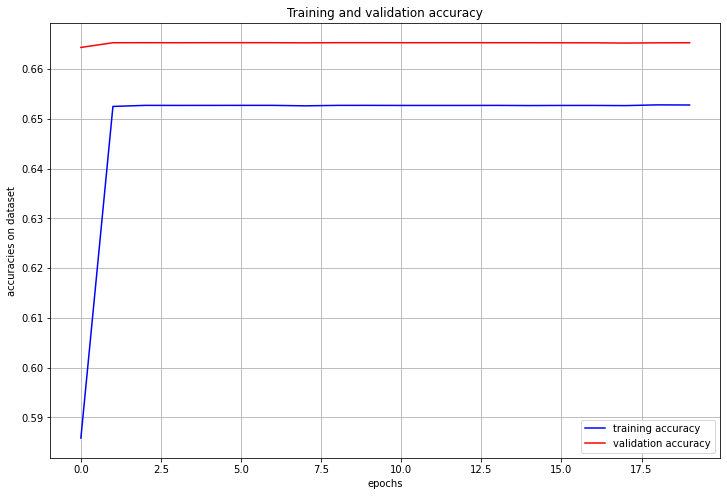

In [9]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
fig = plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'],label='training accuracy', color = "blue")
plt.plot(history.history['val_accuracy'],label='validation accuracy', color = "red")
plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracies on dataset')
plt.grid(True)
plt.title("Training and validation accuracy")
plt.show()
fig.savefig('documentation\\images\\accuracy.jpg')
plt.close(fig)

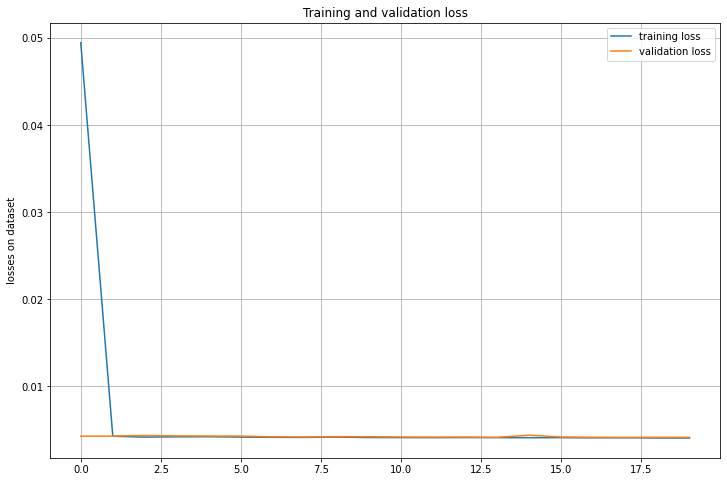

In [10]:
# summarize history for loss
fig = plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend(loc=0)
plt.ylabel('losses on dataset')
plt.grid(True)
plt.title("Training and validation loss")
plt.show()
fig.savefig('documentation//images//loss.jpg')
plt.close(fig)

In [11]:
model_json = model.to_json()
with open('model3.json', 'w') as json_file:
    json_file.write(model_json)

model.save('model3.h5')

In [2]:
color_me = []
for filename in os.listdir('quality/'):
        color_me.append(img_to_array(load_img('quality/'+filename)))
        for i in color_me:
                i = resize(i, (256, 256, 3), mode='constant')
                color_me = np.array(color_me, dtype=float)
                color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
                color_me = color_me.reshape(color_me.shape+(1,))

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
def load_image():
    color_me = []
    resized = []
    for filename in os.listdir('PROJECTS\\Picture_Colorizer\\received\\'):
        color_me.append(img_to_array(load_img('PROJECTS\\Picture_Colorizer\\received\\'+filename)))   
        for i in color_me:
            i = resize(i, (256, 256, 1), mode='constant')
            resized.append(i) 
        resized = np.array(resized, dtype=float)
        resized = rgb2lab(1.0/255*resized)[:,:,:,0]
        resized = resized.reshape(resized.shape+(1,))

        return resized

In [88]:
color_me = []
resized = []
for filename in os.listdir('received\\'):
    color_me.append(img_to_array(load_img('received\\'+filename))) 

In [89]:
    for i in color_me:
        i = cv2.resize(i, (256, 256))

In [90]:
for x in color_me:
    print(x.shape)

(256, 256, 3)


In [68]:
color_me = []
resized = []
for filename in os.listdir('received\\'):
    color_me.append(img_to_array(load_img('received\\'+filename)))   
    for i in color_me:
        i = resize(i, (256, 256, 1), mode='constant')
        resized.append(i)
    resized = np.array(resized, dtype=float)
    resized = rgb2lab(1.0/255*resized)[:,:,:,0]
    resized = resized.reshape(resized.shape+(1,))

ValueError: Input array must have a shape == (..., 3)), got (1, 256, 256, 1)

In [ ]:
def colorize():
    loaded_model = load_model()
    resized = load_image()
    output = loaded_model.predict(resized)
    output = output * 128
    # Output colorizations
    for i in range(len(output)):
        result = np.zeros((256, 256, 3))
        result[:,:,0] = color_me[i][:,:,0]
        result[:,:,1:] = output[i]
        result = lab2rgb(result)
        #result = cv2.resize(result, (1024, 1024, 3))
        #result = cv2.resize(result, (int(size), int(size2))
        imsave("PROJECTS\\Picture_Colorizer\\transformed\\Colorized_"+str(i)+".jpg", (result))
        
    return result

In [34]:
output = model.predict(color_me)
output = output * 128

In [35]:
len(output)

1

In [60]:
# Output colorizations
for i in range(len(output)):
    result = np.zeros((1024, 1024, 3))
    result[:,:,0] = color_me[i][:,:,0]
    result[:,:,1:] = output[i]
    imsave("result4/uint8_"+str(i)+".png", lab2rgb(result))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [13]:
model_json = model.to_json()
with open('model3.json', 'w') as json_file:
    json_file.write(model_json)

model.save('model3.h5')

in_hsv_h = color.convert_colorspace(output, 'RGB', 'HSV')
in_hsv_s = in_hsv_h.copy()
in_hsv_v = in_hsv_h.copy()

for i in range(newImage.shape[0]):
    in_hsv_h[i,:,0] = np.sort(in_hsv_h[i,:,0])
    in_hsv_s[i,:,1] = np.sort(in_hsv_s[i,:,1])
    in_hsv_v[i,:,2] = np.sort(in_hsv_v[i,:,2])

imsave('testing-sorted-hue.png', (color.convert_colorspace(in_hsv_h, 'HSV', 'RGB')*255).astype(np.uint8))
imsave('testing-sorted-saturation.png', (color.convert_colorspace(in_hsv_s, 'HSV', 'RGB')*255).astype(np.uint8))